In [ ]:
%pip install pytorch_lightning

# Importing required packages

In [49]:
import torch
from torch import nn
import torch.quantization
import pytorch_lightning as pl
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback
from pytorch_lightning.loggers import TensorBoardLogger

import pandas as pd
import numpy as np
import requests

# Downloading the MLP dataset

In [50]:
file_name = "MLP.csv"
url = "https://www.dropbox.com/scl/fi/wxc1jz8spd0thbzi4oj3h/mlp_data2.csv?rlkey=p0a22wgqlxdnxm7pum27lh86y&st=mailggnm&dl=1"

response = requests.get(url)

# Save the file locally
with open(file_name, 'wb') as file:
    file.write(response.content)

In [52]:
# Load the CSV into a DataFrame and assign it to the desired column names
df = pd.read_csv(file_name)

df = df[['Max GPU Memory (MiB)', 'Depth', 'Batch Size', 'Total Parameters', 'Total Activations', 'Activations-Params']]

df['Total_Activations_Batch_Size'] = df['Total Activations'] * df['Batch Size']

# Map the existing columns to your desired column structure
df = df.rename(columns={
    'Max GPU Memory (MiB)': 'real_memory_usage',
    'Depth': 'layers',
    'Batch Size': 'batch_size',
    'Total Parameters': 'all_parameters',
    'Total Activations': 'all_activations',
    'Activations-Params': 'params_neurons_list'
})

In [53]:
print(df.columns, "\n\nNumber of columns: ", len(df.columns))

Index(['real_memory_usage', 'layers', 'batch_size', 'all_parameters',
       'all_activations', 'params_neurons_list',
       'Total_Activations_Batch_Size'],
      dtype='object') 

Number of columns:  7


In [54]:
df.head()

,real_memory_usage,layers,batch_size,all_parameters,all_activations,params_neurons_list,Total_Activations_Batch_Size
0,1545,3,996,3560152,7430,"[('linear', 1173, 2753031), ('batch_normalizat...",7400280
1,1569,9,939,3639009,13272,"[('linear', 936, 1754064), ('Softplus', 936, 0...",12462408
2,1507,10,873,1207445,4596,"[('linear', 615, 757065), ('GELU', 615, 0), ('...",4012308
3,1457,4,518,233316,1635,"[('linear', 295, 174640), ('batch_normalizatio...",846930
4,4505,11,983,140336299,74986,"[('linear', 3742, 14006306), ('SELU', 3742, 0)...",73711238


In [55]:
max_layer=0
for i in range(len(df)):
    l = len(eval(df['params_neurons_list'][i]))
    if l>max_layer:
        max_layer=l
print('maximum layers: ', max_layer)

maximum layers:  46


In [56]:
bins = [i*1000 for i in range(1, 6)]  # Define your bin edges

bins.append(float('inf'))
labels = [i for i in range(len(bins)-1)]  # Labels corresponding to the bins

print(labels)
print(bins)
# Use pd.cut() to create a new column with labels based on the bins
df['memory_usage_label'] = pd.cut(df['real_memory_usage'], bins=bins, labels=labels, right=True)


[0, 1, 2, 3, 4]
[1000, 2000, 3000, 4000, 5000, inf]


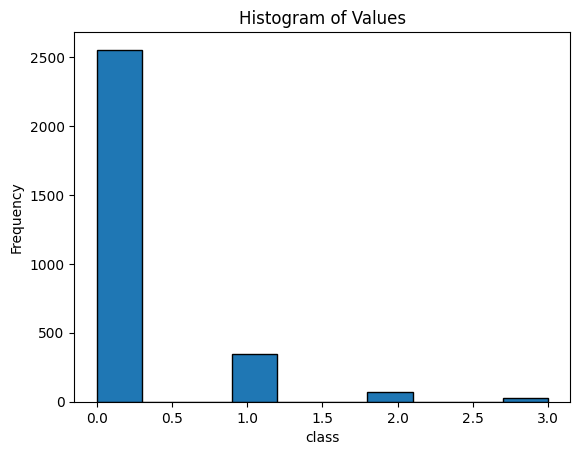

In [58]:
# Plot the histogram
import matplotlib.pyplot as plt

plt.hist(df['memory_usage_label'], bins=len(labels)*2, edgecolor='black')  # bins can be adjusted
plt.title('Histogram of Values')
plt.xlabel('class')
plt.ylabel('Frequency')
plt.show()

In [59]:
print(df.columns)
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(
    df[['params_neurons_list', 'batch_size', 'all_parameters', 'all_activations', 'Total_Activations_Batch_Size']].values, df['memory_usage_label'].values, test_size=0.3, random_state=42)

x_test, x_val, y_test, y_val = train_test_split(
    x_temp, y_temp, test_size=0.66, random_state=42)

print('total data size: ', len(df))
print(f"train size {len(x_train)}, val size: {len(x_val)}, test size: {len(x_test)}")

Index(['real_memory_usage', 'layers', 'batch_size', 'all_parameters',
       'all_activations', 'params_neurons_list',
       'Total_Activations_Batch_Size', 'memory_usage_label'],
      dtype='object')
total data size:  3000
train size 2100, val size: 594, test size: 306


# dataloader FC

In [60]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Define encoding for 'ReLU' and 'linear'
def encode_layer(layer_type):
    if layer_type in ['dropout','batch_normalization', 'Sigmoid', 'Softmax', 'ELU', 'GELU', 'Identity', 'LeakyReLU', 'Mish', 'PReLU', 'ReLU', 'SELU', 'SiLU', 'Softplus', 'Tanh']:
        return [1, 0]
    elif layer_type == 'linear':
        return [0, 1]
    else:
        print(layer_type)
        raise ValueError("Unknown layer type")


# Function to process each sequence
def process_sequence(sequence):
    # print(sequence)
    processed_sequence = []
    for entry in eval(sequence):  # Evaluate string as list of tuples
        # print(entry)
        layer_type, feature_1, feature_2 = entry
        # for fc
        encoded_layer = encode_layer(layer_type)
        combined = encoded_layer + [feature_1, feature_2]
        processed_sequence.append(combined)
    return np.array(processed_sequence)

# Dataset preparation
class LayerSequenceDataset(Dataset):
    def __init__(self, x_data, y_labels, max_seq_len):
        # print(x_data)
        self.x_data = [process_sequence(seq[0]) for seq in x_data]
        self.batch_size = [np.array(seq[1:]).astype(np.int64) for seq in x_data]
        self.y_labels = y_labels
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        sequence = self.x_data[idx]
        batch_size = self.batch_size[idx]
        label = self.y_labels[idx]

        # Padding sequences to max length
        if len(sequence) < self.max_seq_len:
            padded_sequence = np.pad(sequence, ((0, self.max_seq_len - len(sequence)), (0, 0)), 'constant')
        else:
            padded_sequence = sequence[:self.max_seq_len]


        return torch.tensor(padded_sequence, dtype=torch.float32), torch.tensor(label, dtype=torch.long), torch.tensor(batch_size, dtype=torch.float32)



# Example Usage
max_seq_len = max_layer  # Set the max sequence length based on your data
x_train = np.array(x_train)  # Your input sequences here
y_train = np.array(y_train)  # Your labels here

# Initialize dataset and dataloader
train_dataset = LayerSequenceDataset(x_train, y_train, max_seq_len)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = LayerSequenceDataset(x_val, y_val, max_seq_len)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = LayerSequenceDataset(x_test, y_test, max_seq_len)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

inputs, labels, batch_sample = next(iter(train_dataloader))
print(inputs.shape, labels.shape, batch_sample.shape)


torch.Size([32, 46, 4]) torch.Size([32]) torch.Size([32, 4])


# model

In [61]:
import torch.optim as optim

class TransformerClassifier(nn.Module):
    def __init__(self, num_features, num_classes, d_model, nhead, num_layers, dim_feedforward, dropout, max_seq_len):
        super(TransformerClassifier, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Sequential(nn.Linear(num_features, d_model),  # Embedding layer for input features
                                        # nn.LayerNorm(d_model),
                                       nn.BatchNorm1d(max_seq_len),
                                       nn.ReLU(),
                                       nn.Linear(d_model, d_model),
                                       nn.BatchNorm1d(max_seq_len),
                                       nn.ReLU(), )
        # Positional Encoding
        self.positional_encoding = nn.Parameter(self._get_positional_encoding(max_seq_len, d_model), requires_grad=False)

        # Transformer layers
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)

        # Final classification layer
        self.fc_out = nn.Sequential(nn.Linear(d_model+4, d_model),
                                    nn.BatchNorm1d(d_model),
                                    nn.ReLU(),
                                    nn.Linear(d_model, num_classes),
        )

    def _get_positional_encoding(self, max_seq_len, d_model):
        pos_encoding = torch.zeros(max_seq_len, d_model)
        positions = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))

        pos_encoding[:, 0::2] = torch.sin(positions * div_term)
        pos_encoding[:, 1::2] = torch.cos(positions * div_term)

        return pos_encoding.unsqueeze(0)

    def forward(self, x, batch_size_feature):
        # Add positional encoding
        seq_len = x.size(1)
        x = self.embedding(x) + self.positional_encoding[:, :seq_len, :]

        # Transformer encoder
        x = self.transformer_encoder(x)

        # Classification (average pooling over sequence dimension)
        x = x.sum(dim=1)  # Pool over the sequence dimension

        # Ensure batch_size_feature has the correct shape
        batch_size_feature = batch_size_feature.unsqueeze(1) if batch_size_feature.dim() == 1 else batch_size_feature

        # batch_size_feature=batch_size_feature.unsqueeze(1)
        x = torch.cat((x, batch_size_feature), dim=1)

        # Output layer for classification
        output = self.fc_out(x)

        return output

In [71]:
class classification_gpu_usage(pl.LightningModule):
    def __init__(self, output_size):
        super(classification_gpu_usage, self).__init__()
        # Define your model
        self.model = TransformerClassifier(num_features=4, num_classes=len(labels), d_model=4, nhead=4, num_layers=2, dim_feedforward=16, dropout=0.1, max_seq_len=max_layer)
        self.criterion = nn.CrossEntropyLoss()
        # self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, x, b):
        return self.model(x, b)

    def training_step(self, batch, batch_idx):
        x, y, b = batch[0], batch[1], batch[2]
        y = y.long()

        logits = self.forward(x, b)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()

        self.log('train_loss', loss, on_epoch=True, on_step=True)
        self.log('train_acc', acc, on_epoch=True, on_step=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, b = batch[0], batch[1], batch[2]
        y = y.long()
        logits = self.forward(x, b)
        loss = self.criterion(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()

        self.log('val_loss', loss, prog_bar=True, on_epoch=True, on_step=True)
        self.log('val_acc', acc, on_epoch=True, on_step=True)
        return loss

    def configure_optimizers(self):
        # Create a quantized optimizer
        optimizer = Adam(self.parameters(), lr=0.001)

        return optimizer

# Callback

In [73]:
class HistoryCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Access the training loss and accuracy logged during the epoch
        self.train_losses.append(trainer.callback_metrics["train_loss"].item())
        self.train_accuracies.append(trainer.callback_metrics["train_acc"].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        # Access the validation loss and accuracy logged during the epoch
        self.val_losses.append(trainer.callback_metrics["val_loss"].item())
        self.val_accuracies.append(trainer.callback_metrics["val_acc"].item())

    def plot_history(self):
        # Plot training and validation loss
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label="Training Loss")
        plt.plot(self.val_losses, label="Validation Loss")
        plt.title("Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        # Plot training and validation accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label="Training Accuracy")
        plt.plot(self.val_accuracies, label="Validation Accuracy")
        plt.title("Accuracy Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()

In [74]:
# Initialize the history callback
history_callback = HistoryCallback()

# Initialize early stop callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=True, mode='min')

classifier_model = classification_gpu_usage(output_size = len(labels))
classifier_model.train()

trainer = pl.Trainer(
    max_epochs=200,  # you can set this higher, early stopping will halt training
    callbacks=[early_stopping, history_callback],
    # precision='16-mixed',  # Use AMP
    # accelerator='gpu',  # Use GPU if available
    # devices=1  # Number of GPUs
)

# Train the model
trainer.fit(classifier_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                  | Params | Mode 
------------------------------------------------------------
0 | model     | TransformerClassifier | 1.1 K  | train
1 | criterion | CrossEntropyLoss      | 0      | train
------------------------------------------------------------
916       Trainable params
184       Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
36    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 3.584


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.252 >= min_delta = 0.0. New best score: 3.332


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.229 >= min_delta = 0.0. New best score: 3.103


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.202 >= min_delta = 0.0. New best score: 2.901


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.158 >= min_delta = 0.0. New best score: 2.743


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.414 >= min_delta = 0.0. New best score: 2.329


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.745 >= min_delta = 0.0. New best score: 1.584


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.411 >= min_delta = 0.0. New best score: 1.173


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.308 >= min_delta = 0.0. New best score: 0.865


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.218 >= min_delta = 0.0. New best score: 0.647


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.158 >= min_delta = 0.0. New best score: 0.488


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 0.413


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.352


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.319


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 0.289


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.263


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.251


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.236


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.226


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.213


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.203


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.197


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.183


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.180


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.173


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.166


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.162


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.155


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.155


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.151


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.150


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.147


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.142


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.140


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.134


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.131


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.128


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.128


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.121


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.121


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.119


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.118


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.110


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.109


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.105


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.103


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.099


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.097


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.096


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.095


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.092


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.088


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.087


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.086


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.082


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.080


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.076


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.073


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.072


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.069


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.068


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.067


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.066


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 20 records. Best score: 0.066. Signaling Trainer to stop.


In [75]:
classifier_model.eval()
pred_list, gt = list(), list()
with torch.no_grad():
    for test_data in test_dataloader:
        pred = classifier_model(test_data[0],test_data[2])
        # print(f"prediction: {torch.argmax(pred, 1)}, ground truth: {test_data[1]}")
        gt.append(test_data[1].item())
        pred_list.append(torch.argmax(pred, 1).item())

In [76]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def calculate_metrics(gt, preds):
    # Calculate the various metrics
    accuracy = accuracy_score(gt, preds)
    precision = precision_score(gt, preds, average='weighted')  # Use 'weighted' to handle class imbalance
    recall = recall_score(gt, preds, average='weighted')
    f1 = f1_score(gt, preds, average='weighted')
    cm = confusion_matrix(gt, preds)

    # Print the results
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format(f1))
    print("\nConfusion Matrix:")
    print(cm)

    # Full classification report
    print("\nClassification Report:")
    print(classification_report(gt, preds))

calculate_metrics(gt, pred_list)


Accuracy: 0.9706
Precision: 0.9715
Recall: 0.9706
F1-Score: 0.9710

Confusion Matrix:
[[258   2   0   0]
 [  2  32   1   0]
 [  0   0   6   2]
 [  0   0   2   1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       260
           1       0.94      0.91      0.93        35
           2       0.67      0.75      0.71         8
           3       0.33      0.33      0.33         3

    accuracy                           0.97       306
   macro avg       0.73      0.75      0.74       306
weighted avg       0.97      0.97      0.97       306



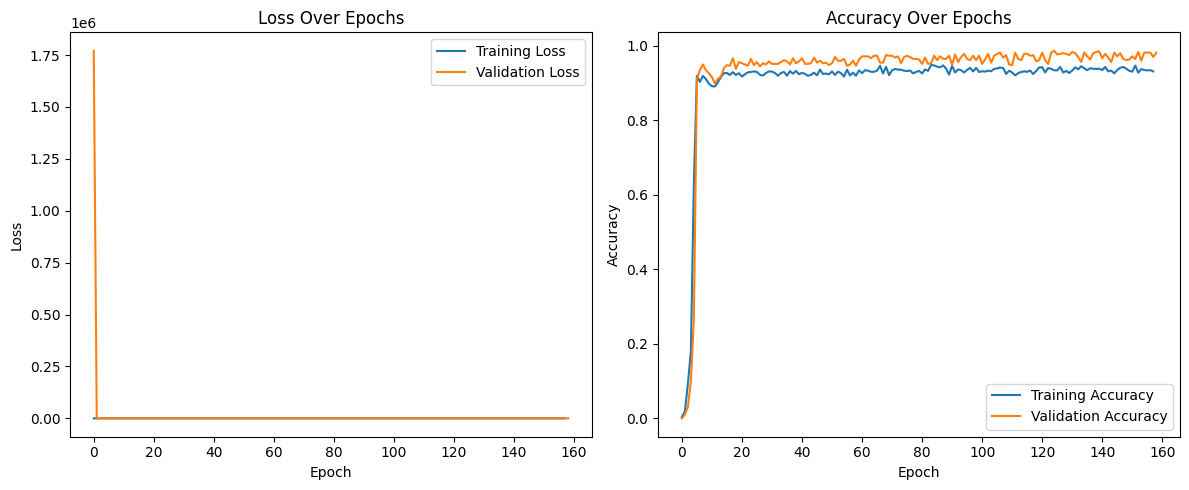

In [77]:
history_callback.plot_history()